In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-price-prediction-challenge/car_price_prediction.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv("/kaggle/input/car-price-prediction-challenge/car_price_prediction.csv")

In [5]:
print(data.shape)
data

(19237, 18)


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,45798355,8467,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,02-Mar,Left wheel,Silver,5
19233,45778856,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,04-May,Left wheel,Red,8
19234,45804997,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
19235,45793526,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,51258 km,4.0,Automatic,Front,04-May,Left wheel,Black,4


In [6]:
data.isnull().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [7]:
data = data.drop('ID', axis=1)

In [8]:
data["Levy"].value_counts()

Levy
-       5819
765      486
891      461
639      410
640      405
        ... 
3156       1
2908       1
1279       1
1719       1
1901       1
Name: count, Length: 559, dtype: int64

In [9]:
data['Levy'] = data['Levy'].replace('-', 0).astype(int)

In [10]:
data['Engine volume'] = data['Engine volume'].astype(str)
data['Engine volume'] = data['Engine volume'].str.extract('(\d+\.?\d*)').astype(float)


In [11]:
data

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,8467,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,0,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0,300000 km,4.0,Manual,Rear,02-Mar,Left wheel,Silver,5
19233,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,04-May,Left wheel,Red,8
19234,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2.0,116365 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
19235,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2.0,51258 km,4.0,Automatic,Front,04-May,Left wheel,Black,4


In [13]:
data['Mileage'] = data['Mileage'].str.replace(' km', '').astype(int)

In [14]:
data['Doors'] = data['Doors'].replace({'04-May': 4, '02-Mar': 2, '>5': 5}).astype(int)


In [15]:
data = data.drop_duplicates()

In [16]:
data

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,4,Left wheel,Silver,12
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,4,Left wheel,Black,8
2,8467,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4,Left wheel,White,0
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19230,470,645,TOYOTA,Prius,2011,Hatchback,Yes,Hybrid,1.8,307325,4.0,Automatic,Front,4,Left wheel,Silver,12
19232,8467,0,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0,300000,4.0,Manual,Rear,2,Left wheel,Silver,5
19233,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600,4.0,Tiptronic,Front,4,Left wheel,Red,8
19234,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2.0,116365,4.0,Automatic,Front,4,Left wheel,Grey,4


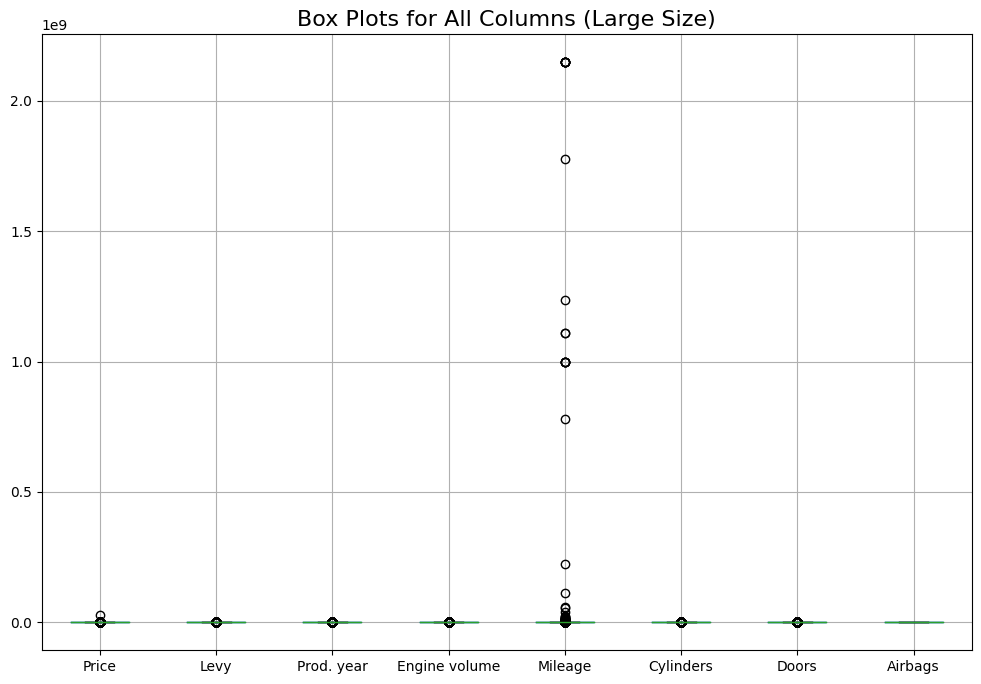

In [21]:
plt.figure(figsize=(12, 8))
data.boxplot()
plt.title("Box Plots for All Columns (Large Size)", fontsize=16)
plt.show()

**see there are outliers for Milleage**

In [22]:
mileage_cap = data['Mileage'].quantile(0.99)   # 99th percentile of Mileage
data['Mileage'] = np.clip(data['Mileage'], 0, mileage_cap)


In [23]:
print(f"Dataset shape after cleaning: {data.shape}")


Dataset shape after cleaning: (15725, 17)


# Exploratory Data Analysis (EDA)

In [24]:
data

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005.0,6.0,Automatic,4x4,4,Left wheel,Silver,12
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000.0,6.0,Tiptronic,4x4,4,Left wheel,Black,8
2,8467,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000.0,4.0,Variator,Front,4,Right-hand drive,Black,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966.0,4.0,Automatic,4x4,4,Left wheel,White,0
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901.0,4.0,Automatic,Front,4,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19230,470,645,TOYOTA,Prius,2011,Hatchback,Yes,Hybrid,1.8,307325.0,4.0,Automatic,Front,4,Left wheel,Silver,12
19232,8467,0,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0,300000.0,4.0,Manual,Rear,2,Left wheel,Silver,5
19233,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600.0,4.0,Tiptronic,Front,4,Left wheel,Red,8
19234,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2.0,116365.0,4.0,Automatic,Front,4,Left wheel,Grey,4


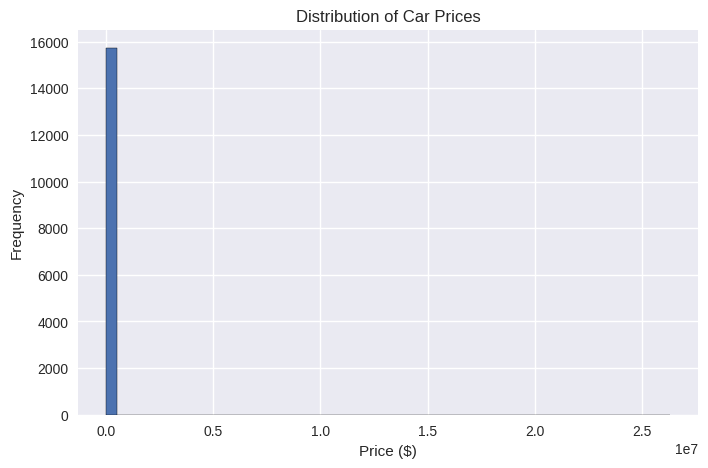

In [40]:
plt.figure(figsize=(8,5))
plt.hist(data['Price'], bins=50, edgecolor='black')
plt.title('Distribution of Car Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()

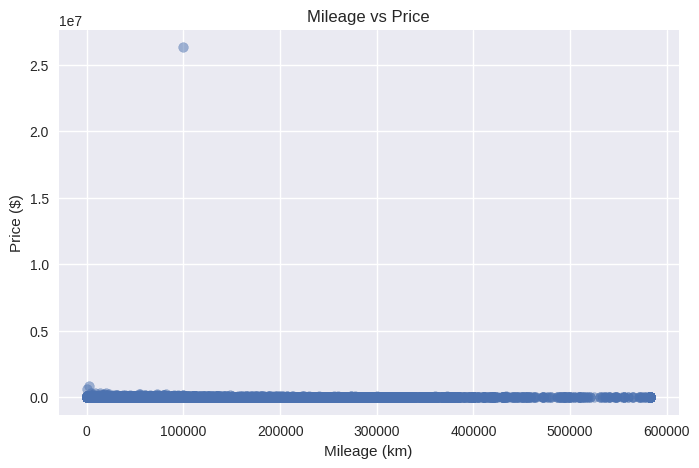

In [41]:
plt.figure(figsize=(8,5))
plt.scatter(data['Mileage'], data['Price'], alpha=0.5)
plt.title('Mileage vs Price')
plt.xlabel('Mileage (km)')
plt.ylabel('Price ($)')
plt.show()


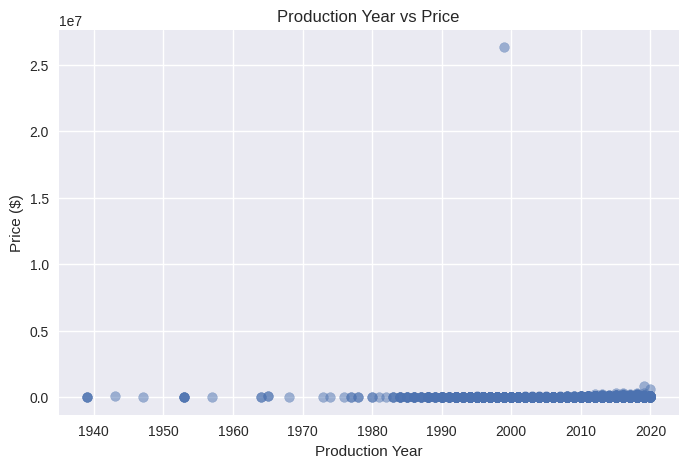

In [42]:
plt.figure(figsize=(8,5))
plt.scatter(data['Prod. year'], data['Price'], alpha=0.5)
plt.title('Production Year vs Price')
plt.xlabel('Production Year')
plt.ylabel('Price ($)')
plt.show()

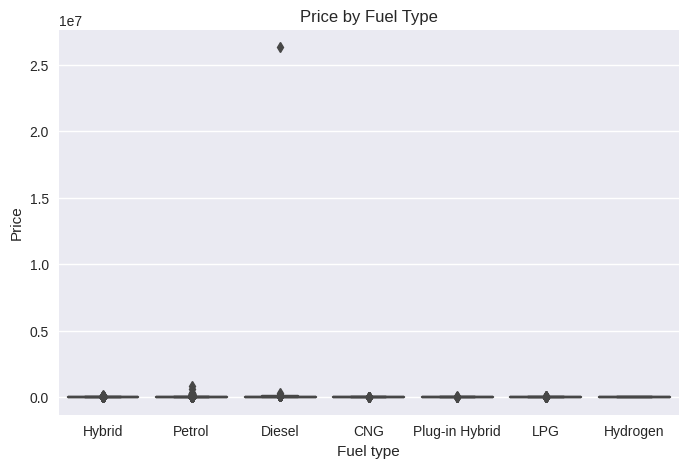

In [43]:
plt.figure(figsize=(8,5))
sns.boxplot(data=data, x='Fuel type', y='Price')
plt.title('Price by Fuel Type')
plt.show()

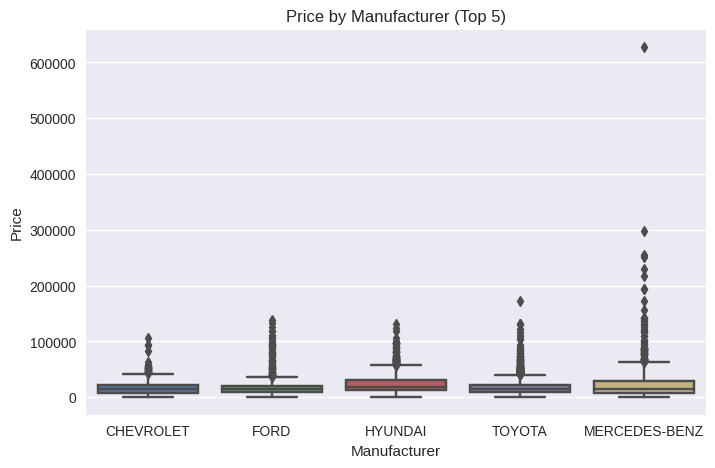

In [44]:
top_manufacturers = data['Manufacturer'].value_counts().index[:5]
plt.figure(figsize=(8,5))
sns.boxplot(data=data[data['Manufacturer'].isin(top_manufacturers)], x='Manufacturer', y='Price')
plt.title('Price by Manufacturer (Top 5)')
plt.show()

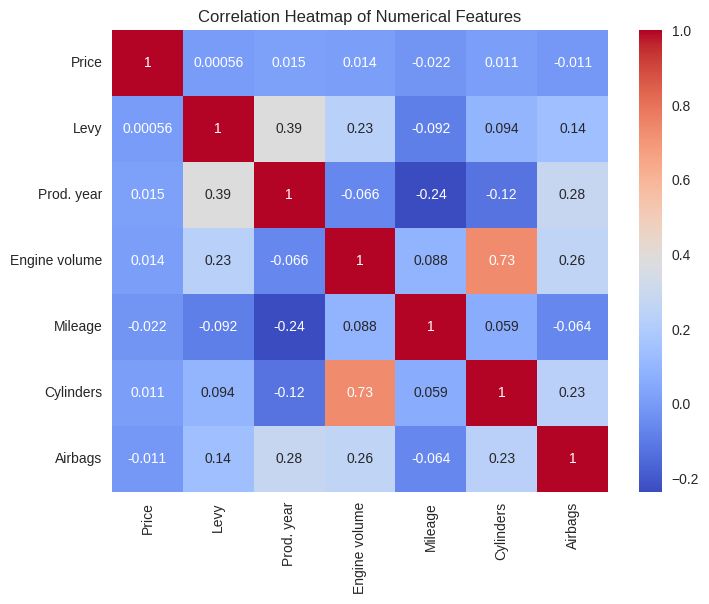

In [45]:
plt.figure(figsize=(8,6))
sns.heatmap(data[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

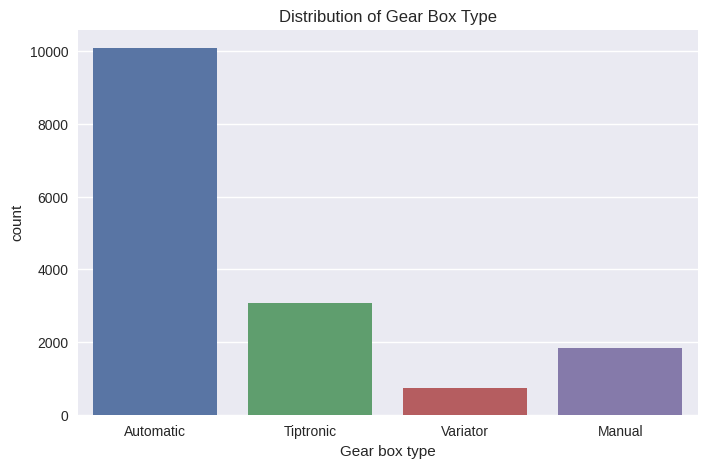

In [46]:
plt.figure(figsize=(8,5))
sns.countplot(data=data, x='Gear box type')
plt.title('Distribution of Gear Box Type')
plt.show()

In [47]:
le = LabelEncoder()
for col in categorical_cols:
    data[col] = le.fit_transform(data[col].astype(str))


In [48]:
X = data.drop('Price', axis=1)
y = np.log1p(data['Price'])

In [52]:
X

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,1399,32,1242,2010,4,1,2,3.5,186005.0,6.0,0,0,4,0,12,12
1,1018,8,658,2011,4,0,5,3.0,192000.0,6.0,2,0,4,0,1,8
2,0,21,684,2006,3,0,5,1.3,200000.0,4.0,3,1,4,1,1,2
3,862,16,661,2011,4,1,2,2.5,168966.0,4.0,0,0,4,0,14,0
4,446,21,684,2014,3,1,5,1.3,91901.0,4.0,0,1,4,0,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19230,645,58,1154,2011,3,1,2,1.8,307325.0,4.0,0,1,4,0,12,12
19232,0,36,385,1999,1,1,0,2.0,300000.0,4.0,1,2,2,0,12,5
19233,831,23,1334,2011,9,1,5,2.4,161600.0,4.0,2,1,4,0,11,8
19234,836,23,1442,2010,4,1,1,2.0,116365.0,4.0,0,1,4,0,7,4


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [56]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_orig = np.expm1(y_pred)  # Back to original scale
y_test_orig = np.expm1(y_test)

mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2 = r2_score(y_test_orig, y_pred_orig)

print(f'MAE: ${mae:.2f}')
print(f'RMSE: ${rmse:.2f}')
print(f'R²: {r2:.4f}')

MAE: $6689.11
RMSE: $12243.15
R²: 0.5304


In [57]:
selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
grid = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid, cv=3, scoring='r2')
grid.fit(X_train_selected, y_train)

# Best model
best_model = grid.best_estimator_
y_pred_tuned = best_model.predict(X_test_selected)
y_pred_orig_tuned = np.expm1(y_pred_tuned)

mae_tuned = mean_absolute_error(y_test_orig, y_pred_orig_tuned)
r2_tuned = r2_score(y_test_orig, y_pred_orig_tuned)
print(f'Tuned MAE: ${mae_tuned:.2f}')
print(f'Tuned R²: {r2_tuned:.4f}')

Tuned MAE: $6737.90
Tuned R²: 0.5323


In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Define the model
model = RandomForestRegressor(
    n_estimators=500,      # Number of trees
    max_depth=20,           # Maximum depth of each tree
    random_state=42        # For reproducibility
)

# 2. Train the model
model.fit(X_train, y_train)

# 3. Predict on test set
y_pred = model.predict(X_test)

# 4. If target was log-transformed, convert back
y_pred_orig = np.expm1(y_pred)
y_test_orig = np.expm1(y_test)

# 5. Evaluate
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2 = r2_score(y_test_orig, y_pred_orig)

# 6. Print results
print(f'MAE: ${mae:.2f}')
print(f'RMSE: ${rmse:.2f}')
print(f'R²: {r2:.4f}')


MAE: $5813.28
RMSE: $11395.73
R²: 0.5932


In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],       # Number of trees
    'max_depth': [None, 5, 10, 20],        # Maximum depth
    'min_samples_split': [2, 5, 10],       # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],         # Minimum samples at leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Features considered at each split
}

# 2. Create Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# 3. Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1,         # Use all CPU cores
    scoring='neg_mean_squared_error',  # Minimize MSE
    verbose=1
)

# 4. Fit grid search on training data
grid_search.fit(X_train, y_train)

# 5. Get the best model
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# 6. Predict on test set
y_pred = best_rf.predict(X_test)

# 7. Convert back if target was log-transformed
y_pred_orig = np.expm1(y_pred)
y_test_orig = np.expm1(y_test)

# 8. Evaluate
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2 = r2_score(y_test_orig, y_pred_orig)

print(f'MAE: ${mae:.2f}')
print(f'RMSE: ${rmse:.2f}')
print(f'R²: {r2:.4f}')


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
MAE: $5958.20
RMSE: $11581.69
R²: 0.5798
